# Implementation of Variational AutoEncoder (VAE)

     This is based on "Auto-Encoding Variational Bayes" (2014, D.P. Kingma et. al.)

### Step 1. Import the required libraries
In this section, we import the required libraries for our VAE implementation.

**torch** is PyTorch, the deep learning framework used for building and training neural networks.
**torch.nn** contains the tools for defining neural network architectures.
**torch.optim** is used for optimization algorithms like Adam.
**datasets** and **transforms** from **torchvision** are for loading and transforming datasets.
**matplotlib.pyplot** is used for plotting images and graphs.

In [42]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch.utils.data import random_split, DataLoader

In [43]:
# Check if a GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Step 2. Define our model: Variational AutoEncoder (VAE)
This section defines the architecture of the Variational Autoencoder (VAE) using PyTorch's neural network module (**nn.Module**). The VAE consists of two parts: an encoder and a decoder.

The encoder takes the input image, flattens it, and passes it through a series of fully connected layers with ReLU activations. The final layer outputs two times the latent_dim values, representing the mean and log-variance of the latent distribution.
The decoder takes a sample from the latent space and passes it through a series of fully connected layers with ReLU activations. The final layer produces the output image, which is sigmoid activated to ensure pixel values are between 0 and 1.

In [44]:
# Define the VAE architecture
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 2 * latent_dim)  # Two times latent_dim for mean and log-variance
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 28 * 28),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        mu, log_var = torch.chunk(h, 2, dim=-1)  # Split into mean and log-variance
        return mu, log_var

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        epsilon = torch.randn_like(std)
        return mu + epsilon * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        reconstruction = self.decode(z)
        return reconstruction, mu, log_var

### Step 3. Define Loss function
This section defines the loss function for the VAE. The VAE loss consists of two components:

The **reconstruction loss**, calculated as the binary cross-entropy (BCE) between the reconstructed image (reconstruction) and the original input image (x).
The **KL divergence regularization** term, which ensures that the learned latent space is close to a standard Gaussian distribution. This term encourages the encoder to learn a meaningful representation in the latent space.

In [45]:
# Define the VAE loss function
def vae_loss(reconstruction, x, mu, log_var):
    # Reconstruction loss (BCE)
    reconstruction_loss = nn.functional.binary_cross_entropy(reconstruction, x, reduction='sum')

    # KL divergence regularization term
    kl_divergence = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

    return reconstruction_loss + kl_divergence

###    Step 4. Load or download Dataset
We load and preprocess the MNIST dataset. We use **transforms.ToTensor()** to convert the images to PyTorch tensors and create a data loader to efficiently load and iterate through the dataset in batches.

In [46]:
# Load and preprocess the dataset
transform = transforms.Compose([transforms.ToTensor()])
dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)

# Split the dataset into training and validation sets (e.g., 80% training, 20% validation)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create data loaders for training and validation
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

### Step 5. Initialize our model and define an optimizer
Here, we initialize the VAE model with a specified latent dimension of 20. This model will be used for training and generating samples.

We then define an Adam optimizer to update the parameters of the VAE during training. We optimize the parameters of both the encoder and decoder.

In [47]:
# Initialize the VAE and move it to the GPU
latent_dim = 20
vae = VAE(latent_dim).to(device)

# Define the optimizer
optimizer = optim.Adam(vae.parameters(), lr=0.001)

### Step 6. Train our VAE
This section contains the training loop for the VAE. We iterate over the dataset for a specified number of epochs and update the model's parameters using backpropagation. The loss is calculated using the VAE loss function, and the average loss per data point is printed for each epoch.

In [48]:
# Training loop with validation
epochs = 10
for epoch in range(epochs):
    # Training
    vae.train()
    total_train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.view(-1, 28 * 28).to(device)
        optimizer.zero_grad()
        reconstruction, mu, log_var = vae(data)
        loss = vae_loss(reconstruction, data, mu, log_var)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    # Validation
    vae.eval()
    total_val_loss = 0
    with torch.no_grad():
        for batch_idx, (data, _) in enumerate(val_loader):
            data = data.view(-1, 28 * 28).to(device)
            reconstruction, mu, log_var = vae(data)
            loss = vae_loss(reconstruction, data, mu, log_var)
            total_val_loss += loss.item()

    print(f"Epoch [{epoch + 1}/{epochs}] Train Loss: {total_train_loss / len(train_dataset):.4f} Val Loss: {total_val_loss / len(val_dataset):.4f}")

Epoch [1/10] Train Loss: 177.6325 Val Loss: 142.2394
Epoch [2/10] Train Loss: 132.0699 Val Loss: 124.1157
Epoch [3/10] Train Loss: 120.4631 Val Loss: 117.1334
Epoch [4/10] Train Loss: 115.4068 Val Loss: 113.9047
Epoch [5/10] Train Loss: 112.4607 Val Loss: 111.5512
Epoch [6/10] Train Loss: 110.6649 Val Loss: 110.1186
Epoch [7/10] Train Loss: 109.2026 Val Loss: 109.0029
Epoch [8/10] Train Loss: 108.1659 Val Loss: 107.9978
Epoch [9/10] Train Loss: 107.3222 Val Loss: 107.3267
Epoch [10/10] Train Loss: 106.6893 Val Loss: 106.7992


### Step 7. Generate images from the trained VAE model
Here, we generate 16 random samples from the VAE's latent space. These samples are drawn from a standard Gaussian distribution and then passed through the decoder to generate new images.

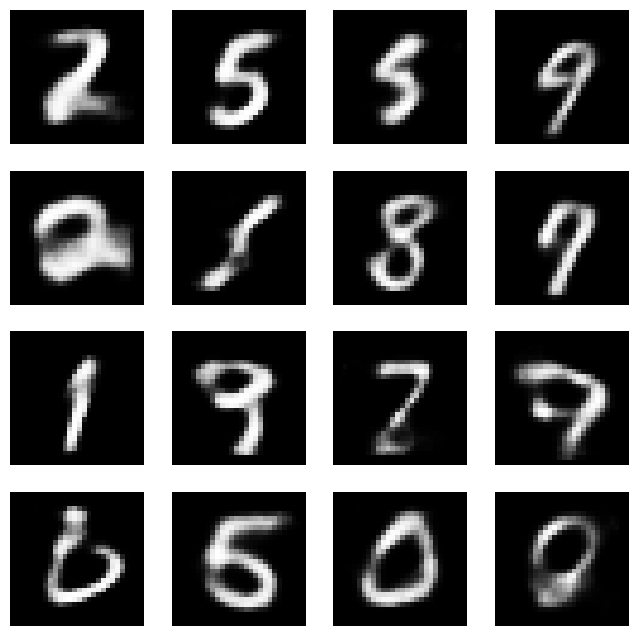

In [49]:
# Generate samples from the VAE on CUDA (GPU)
with torch.no_grad():
    z_samples = torch.randn(16, latent_dim).to(device)  # Generate random samples on the GPU
    generated_samples = vae.decode(z_samples).cpu()  # Generate and move samples to CPU for visualization

# Visualize generated samples
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
for i in range(16):
    ax = axes[i // 4, i % 4]
    ax.imshow(generated_samples[i].view(28, 28).numpy(), cmap='gray')
    ax.axis('off')
plt.show()

**1** You may try to play with the model by modifying the model structures (adding or deleting some layers, changing the dimension of the layers) or trying different hyperparameters like learning rate, epochs,...

**2** Think about how we can improve the performance